In [1]:
# notebook for exploring MLP
# goals are to: create an initial MLP just to see and test a couple things
# want to test how we can save the logic and then mask over outputted moves and play a game against a computer
# test doing training on the GPU and shipping it over to there
# test running some metrics on it
import chess
import torch
import numpy as np
import chess.pgn
import pandas as pd
import matplotlib.pyplot as plt

torch.set_printoptions(threshold=5000)
torch.set_printoptions(linewidth=2000)
torch.set_printoptions(edgeitems=5000)


In [2]:
# load in data and split it into train and test
sample_data_path = './training_data/processed_first_1000_games_tensors.pt'
data = torch.load(sample_data_path)
print(data.keys())


/tmp/ipykernel_23134/951602630.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(sample_data_path)


dict_keys(['boards', 'moves'])


In [3]:
boards = data['boards']
moves = data['moves']

In [4]:
moves.shape, boards.shape

(torch.Size([75543, 75, 8, 8]), torch.Size([75543, 119, 8, 8]))

In [5]:
import math
split_point = math.floor(moves.shape[0] * 0.85)
x_train = boards[:split_point]
x_val = boards[split_point:]
y_train = moves[:split_point]
y_val = moves[split_point:]

In [5]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# class MLP(nn.Module):
#     def __init__(self, input_shape, output_shape, hidden_size):
#         super(MLP, self).__init__()

#         self.input_shape = input_shape
#         self.output_shape = output_shape

#         self.flat_input_size = input_shape[0] * input_shape[1] * input_shape[2]
        
#         self.flat_output_size = output_shape[0] * output_shape[1] * output_shape[2]
        
#         self.flatten = nn.Flatten(start_dim=1)
        
#         self.layer1 = nn.Linear(self.flat_input_size, hidden_size)
#         self.layer2 = nn.Linear(hidden_size, hidden_size)
#         self.layer3 = nn.Linear(hidden_size, self.flat_output_size)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.flatten(x)
#         x = self.relu(self.layer1(x))
#         x = self.relu(self.layer2(x))
#         x = self.layer3(x)
#         x = x.view(-1, *self.output_shape)
#         return x

In [6]:
# new model
import torch.nn.functional as F
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_sizes):
        super(MLP, self).__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.flat_input_size = input_shape[0] * input_shape[1] * input_shape[2]
        self.flat_output_size = output_shape[0] * output_shape[1] * output_shape[2]
        
        self.flatten = nn.Flatten(start_dim=1)
        
        layers = []
        prev_size = self.flat_input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(0.1))
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, self.flat_output_size))
        
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        x = x.view(-1, 75, 8, 8)
        return F.softmax(x, dim=1) 

In [20]:
# new model
import torch.nn.functional as F
import torch.nn as nn

# (torch.Size([75543, 75, 8, 8]), torch.Size([75543, 119, 8, 8]))

class CNN_MLP(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(CNN_MLP, self).__init__()
        self.flat_output_size = output_shape[0] * output_shape[1] * output_shape[2]

        self.input_shape = input_shape
        self.output_shape = output_shape
        
        self.conv1 = nn.Conv2d(in_channels=119, out_channels=256, kernel_size=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(4608, 8192)
        self.relu3 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(8192)
        self.dp1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(8192, self.flat_output_size)
        self.relu4 = nn.ReLU()



    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.bn1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.relu4(x)
        
        x = x.view(-1, 75, 8, 8)
        return F.softmax(x, dim=1) 

In [9]:
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print("epoch started")
        model.train()
        running_loss = 0.0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return train_losses, val_losses


def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [12]:
from torch.utils.data import TensorDataset, DataLoader

# input_shape = (119, 8, 8)
# output_shape = (75, 8, 8)

# model = MLP(input_shape, output_shape, 8192).to(device)

# train_dataset = TensorDataset(x_train, y_train)

# num_epochs = 50
# batch_size = 32

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
    
#     for batch_x, batch_y in train_loader:
#         batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
#         # Forward pass
#         outputs = model(batch_x)
#         loss = criterion(outputs, batch_y)
        
#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
    
#     epoch_loss = running_loss / len(train_loader)
#     if (epoch + 1) % 10 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')


epoch started
Epoch [1/20], Train Loss: 0.2661, Val Loss: 0.1372
epoch started
Epoch [2/20], Train Loss: 0.2589, Val Loss: 0.1391
epoch started
Epoch [3/20], Train Loss: 0.2586, Val Loss: 0.1389
epoch started
Epoch [4/20], Train Loss: 0.2540, Val Loss: 0.1270
epoch started
Epoch [5/20], Train Loss: 0.2323, Val Loss: 0.0915
epoch started
Epoch [6/20], Train Loss: 0.1969, Val Loss: 0.0853
epoch started
Epoch [7/20], Train Loss: 0.1809, Val Loss: 0.1092
epoch started
Epoch [8/20], Train Loss: 0.1637, Val Loss: 0.1050
epoch started
Epoch [9/20], Train Loss: 0.1518, Val Loss: 0.0980
epoch started
Epoch [10/20], Train Loss: 0.1385, Val Loss: 0.0954
epoch started
Epoch [11/20], Train Loss: 0.1328, Val Loss: 0.1142
epoch started
Epoch [12/20], Train Loss: 0.1244, Val Loss: 0.0933
epoch started
Epoch [13/20], Train Loss: 0.1040, Val Loss: 0.1165
epoch started
Epoch [14/20], Train Loss: 0.0935, Val Loss: 0.0918
epoch started
Epoch [15/20], Train Loss: 0.0806, Val Loss: 0.1201
epoch started
Epoch

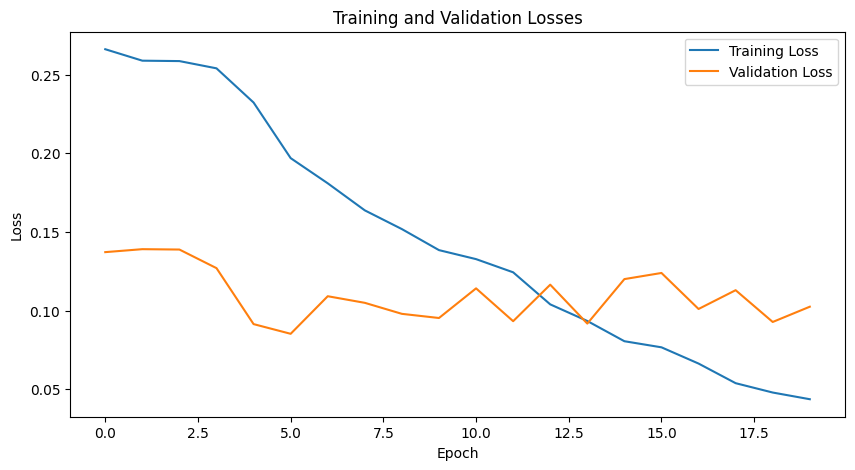

In [21]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Model parameters
input_shape = (119, 8, 8)
output_shape = (75, 8, 8)
hidden_sizes = [4096, 4096, 4096, 2048]  # Multiple hidden layers with different sizes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = MLP(input_shape, output_shape, hidden_sizes).to(device)
model = CNN_MLP(input_shape, output_shape).to(device)

# Prepare data loaders (assuming you have validation data)
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Training parameters
num_epochs = 20
# changed this to cross entropy loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device)

# Plot the losses
plot_losses(train_losses, val_losses)

In [25]:
torch.save(model.state_dict(), './models/mlp_model_trained.pth')

In [22]:
torch.save(model.state_dict(), './models/cnn_model_trained.pth')

In [ ]:
# this is the most basic model

In [22]:
import chess
import random

def get_computer_move(board):
    return random.choice(list(board.legal_moves))

def play_game_commandline():
    board = chess.Board()

    while not board.is_game_over():
        display(board)
        
        # Human's turn (White)
        while True:
            try:
                move = chess.Move.from_uci(input("Your move: "))
                if move in board.legal_moves:
                    board.push(move)
                    break
                else:
                    print("Illegal move. Try again.")
            except ValueError:
                print("Invalid input. Please use UCI notation (e.g., 'e2e4')")

        if board.is_game_over():
            break

        ai_move = get_computer_move(board)
        print(f"\nAI move: {ai_move}")
        board.push(ai_move)

    print("\nGame Over")
    print(f"Result: {board.result()}")
    display(board)

# play_game_commandline()

# our objective is not to replace get_computer_move with our models move

In [23]:
# create a way to load in model
loaded_model = MLP(input_shape, output_shape, [4096, 4096, 4096, 4096])
loaded_model.load_state_dict(torch.load("./models/mlp_model_trained.pth"))

/tmp/ipykernel_47404/1044947189.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("./models/mlp_model_trained.pth"))


<All keys matched successfully>

In [38]:
loaded_model = CNN_MLP(input_shape, output_shape)
loaded_model.load_state_dict(torch.load("./models/cnn_model_trained.pth"))

/tmp/ipykernel_23134/3832404150.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("./models/cnn_model_trained.pth"))


<All keys matched successfully>

In [39]:
def create_board_representation(board: chess.Board):
    # here we will return the first 12 8x8 tensors of where the pieces are
    # takes in a python chess board

    tensors = torch.zeros(12, 8, 8, dtype=torch.float32)

    piece_to_index = {
        (chess.PAWN, chess.WHITE): 0,
        (chess.KNIGHT, chess.WHITE): 1,
        (chess.BISHOP, chess.WHITE): 2,
        (chess.ROOK, chess.WHITE): 3,
        (chess.QUEEN, chess.WHITE): 4,
        (chess.KING, chess.WHITE): 5,
        (chess.PAWN, chess.BLACK): 6,
        (chess.KNIGHT, chess.BLACK): 7,
        (chess.BISHOP, chess.BLACK): 8,
        (chess.ROOK, chess.BLACK): 9,
        (chess.QUEEN, chess.BLACK): 10,
        (chess.KING, chess.BLACK): 11,
    }

    for square, piece in board.piece_map().items():
        if piece is not None:
            index = piece_to_index[(piece.piece_type, piece.color)]
            row, col = divmod(square, 8)
            tensors[index, row, col] = 1.0

    return tensors

def create_turn_tensor(board):
    return torch.ones(8,8) if board.turn == chess.WHITE else torch.zeros(8,8)

def create_total_move_count_tensor(moves):
    return torch.full((8, 8), moves, dtype=torch.float32)

def create_no_progress_tensor(board):
    return torch.full((8, 8), board.halfmove_clock, dtype=torch.float32)
    

def create_castling_tensor(board):
    bitmask = board.castling_rights
    white_kingside = float(bool(bitmask & chess.BB_H1))
    white_queenside = float(bool(bitmask & chess.BB_A1))
    black_kingside = float(bool(bitmask & chess.BB_H8))
    black_queenside = float(bool(bitmask & chess.BB_A8))
    
    castling_tensor = torch.zeros(4, 8, 8)
    castling_tensor[0].fill_(white_kingside)
    castling_tensor[1].fill_(white_queenside)
    castling_tensor[2].fill_(black_kingside)
    castling_tensor[3].fill_(black_queenside)
    
    return castling_tensor
    

def create_repetition_count_tensor(board: chess.Board) -> torch.Tensor:
    repetition_tensor = torch.zeros(2, 8, 8, dtype=torch.float32)
    
    if board.is_repetition(2):
        repetition_tensor[0].fill_(1)
    
    if board.is_repetition(3):
        repetition_tensor[1].fill_(1)
    
    return repetition_tensor

In [40]:
# create way to take a chess board from python chess and turn it into our board input tensor (with history)
def turn_board_state_into_input(board, timesteps = 8):
    x = torch.zeros(timesteps * 14 + 7, 8, 8)
    
    board_representation = create_board_representation(board)
    repetition_count_representation = create_repetition_count_tensor(board)
    turn_representation = create_turn_tensor(board)
    move_number_representation = create_total_move_count_tensor(board.fullmove_number)
    castling_right_tensors = create_castling_tensor(board)
    no_progress_tensor = create_no_progress_tensor(board)

    board_history = torch.zeros(timesteps - 1, 14, 8, 8)
    
    for i in range(min(timesteps - 1, len(board.move_stack))):
        board_copy = board.copy()
        for _ in range(len(board.move_stack) - i - 1):
            board_copy.pop()
        
        historical_board_representation = create_board_representation(board_copy)
        historical_repetition_count = create_repetition_count_tensor(board_copy)
        
        board_history[timesteps - 2 - i, :12] = historical_board_representation
        board_history[timesteps - 2 - i, 12:] = historical_repetition_count

    # Combine all representations
    x = torch.cat([
        board_history.view(-1, 8, 8),
        board_representation,
        repetition_count_representation,
        turn_representation.unsqueeze(0),
        move_number_representation.unsqueeze(0),
        castling_right_tensors,
        no_progress_tensor.unsqueeze(0)
    ], dim=0)

    return x
    
    

In [41]:
def generate_uci_moves_dict():
    files = 'abcdefgh'
    ranks = '12345678'
    pieces = 'rnbqkbnr'
    promotions = 'rnbq'
    
    moves = {}
    
    for start_file in files:
        for start_rank in ranks:
            for end_file in files:
                for end_rank in ranks:
                    move = f"{start_file}{start_rank}{end_file}{end_rank}"
                    moves[move] = move
    
    # Generate pawn promotions
    for start_file in files:
        for end_file in files:
            # White pawn promotions
            for promotion in promotions:
                move = f"{start_file}7{end_file}8{promotion}"
                moves[move] = move
            # Black pawn promotions
            for promotion in promotions:
                move = f"{start_file}2{end_file}1{promotion}"
                moves[move] = move
    
    return moves

# Example usage
uci_moves = generate_uci_moves_dict()
print(f"Total number of moves: {len(uci_moves)}")
print("Example moves:")
print(list(uci_moves.keys())[-10:])

Total number of moves: 4608
Example moves:
['h2g1b', 'h2g1q', 'h7h8r', 'h7h8n', 'h7h8b', 'h7h8q', 'h2h1r', 'h2h1n', 'h2h1b', 'h2h1q']


In [48]:
import chess

# create a map of uci moves (all 64 x 64 + whatever we need for under promotions) to tensor indexes
# we will then use the python board to quickly get all legal moves and then grab the probabilities for each of those moves
# then we will renormalize them and select a move


def generate_uci_to_tensor_index_mapping():
    mapping = {}
    board = chess.Board()

    # Regular moves (0-55)
    directions = [
        (1, 0),   # North
        (1, 1),   # North-East
        (0, 1),   # East
        (-1, 1),  # South-East
        (-1, 0),  # South
        (-1, -1), # South-West
        (0, -1),  # West
        (1, -1)   # North-West
    ]

    for start_square in chess.SQUARES:
        start_rank = chess.square_rank(start_square)
        start_file = chess.square_file(start_square)
        for dir_idx, (rank_diff, file_diff) in enumerate(directions):
            for distance in range(1, 8):
                end_rank = start_rank + rank_diff * distance
                end_file = start_file + file_diff * distance
                if 0 <= end_rank < 8 and 0 <= end_file < 8:
                    end_square = chess.square(end_file, end_rank)
                    move = chess.Move(start_square, end_square)
                    uci = move.uci()
                    plane_index = dir_idx * 7 + (distance - 1)
                    mapping[uci] = (plane_index, start_rank, start_file)

    # Knight moves (56-63)
    knight_moves = [
        (2, 1), (1, 2), (-1, 2), (-2, 1),
        (-2, -1), (-1, -2), (1, -2), (2, -1)
    ]
    for start_square in chess.SQUARES:
        start_rank = chess.square_rank(start_square)
        start_file = chess.square_file(start_square)
        for i, (rank_diff, file_diff) in enumerate(knight_moves):
            end_rank = start_rank + rank_diff
            end_file = start_file + file_diff
            if 0 <= end_rank < 8 and 0 <= end_file < 8:
                end_square = chess.square(end_file, end_rank)
                move = chess.Move(start_square, end_square)
                uci = move.uci()
                mapping[uci] = (56 + i, start_rank, start_file)

    # Pawn promotions (64-72)
    promotions = [chess.QUEEN, chess.ROOK, chess.BISHOP, chess.KNIGHT]
    for color in [chess.WHITE, chess.BLACK]:
        pawn_rank = 6 if color == chess.WHITE else 1
        for file in range(8):
            start_square = chess.square(file, pawn_rank)
            for file_diff in [-1, 0, 1]:
                if 0 <= file + file_diff < 8:
                    end_square = chess.square(file + file_diff, 7 if color == chess.WHITE else 0)
                    for promotion in promotions:
                        move = chess.Move(start_square, end_square, promotion)
                        uci = move.uci()
                        file_index = file_diff + 1  # -1 -> 0, 0 -> 1, 1 -> 2
                        promotion_index = promotions.index(promotion)
                        plane_index = 64 + file_index * 3 + promotion_index
                        mapping[uci] = (plane_index, pawn_rank, file)

    return mapping

uci_to_tensor_index = generate_uci_to_tensor_index_mapping()
print(f"Total number of mapped moves: {len(uci_to_tensor_index)}")
# for uci, indices in list(uci_to_tensor_index.items()):
#     print(f"{uci}: plane={indices[0]}, rank={indices[1]}, file={indices[2]}")

Total number of mapped moves: 1968


In [49]:
# takes in a move tensor, and gets the probabilities of all legal moves from it
def get_legal_move_probabilities(move_tensor, uci_to_tensor_index, board):
    moves = {}
    for move in board.legal_moves:
        move_uci = move.uci()
        indicies = uci_to_tensor_index.get(move_uci)
        move_probability = move_tensor[indicies[0]][indicies[1]][indicies[2]]
        moves[move_uci] = move_probability.item()
    return moves


In [ ]:
# combine above methods to create an interactive way to play against the model
# updated game loop

import chess
import random

loaded_model.eval()

def get_computer_move(board):
    # convert board into input type
    input_board = turn_board_state_into_input(board)
    input_board = input_board.unsqueeze(0)
    input_board.to(device)

    # get output tensor from model

    with torch.no_grad():
        output = loaded_model(input_board)

    output = output.view(75, 8, 8)
    
    # get probabilities of legal moves and play the best one
    legal_moves = get_legal_move_probabilities(output, uci_to_tensor_index, board)
    highest_prob = 0
    curr_move = ""
    for move, prob in legal_moves.items():
        if(prob > highest_prob):
            highest_prob = prob
            curr_move = move
            
    return chess.Move.from_uci(curr_move)

def play_game_commandline():
    board = chess.Board()

    while not board.is_game_over():
        display(board)
        
        # Human's turn (White)
        while True:
            try:
                move = chess.Move.from_uci(input("Your move: "))
                if move in board.legal_moves:
                    board.push(move)
                    break
                else:
                    print("Illegal move. Try again.")
            except ValueError:
                print("Invalid input. Please use UCI notation (e.g., 'e2e4')")

        if board.is_game_over():
            break

        ai_move = get_computer_move(board)
        print(f"\nAI move: {ai_move}")
        board.push(ai_move)

    print("\nGame Over")
    print(f"Result: {board.result()}")
    display_board(board)

play_game_commandline()

# our objective is not to replace get_computer_move with our models move

In [ ]:
# played it once and it's not good
print("hi")

In [ ]:
# add ability to play game against random legal moves from AI and see how that does
import chess.pgn

def play_against_random(model_is_white, get_model_move_function, display_game = False, max_moves = 400):
    board = chess.Board()

    moves = 0
    
    while not board.is_game_over():
        if(moves >= max_moves): break
        if(model_is_white and moves == 0):
            model_move = get_model_move_function(board)
            board.push(model_move)

        if(display_game):
            print(f"Model Move: {model_move}")
            display(board)

        # play random computer move
        legal_moves = [move for move in board.legal_moves]
        move = legal_moves[random.randint(0, len(legal_moves) - 1)]
        board.push(move)


        if(display_game):
            print(f"random move: {move}")
            display(board)

        if(board.is_game_over()):
            game = chess.pgn.Game.from_board(board)
            if(game.headers["Result"] != "1/2-1/2"):
                print(game)
            break
        

        # play model move
        model_move = get_model_move_function(board)
        if(display_game):
            print(f"Model Move: {model_move}")
        board.push(model_move)

        if(board.is_game_over()):
            game = chess.pgn.Game.from_board(board)
            if(game.headers["Result"] != "1/2-1/2"):
                print(game)
            break
        

            
        moves += 1

print("model white")
play_against_random(True, get_computer_move)


for i in range(0, 50):
    if(i <= 25):
        print("model white")
        play_against_random(True, get_computer_move)
    if(i > 25):
        print("model black")
        play_against_random(False, get_computer_move)
    
    


model white
model white
model white
model white
[Event "?"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "?"]
[Black "?"]
[Result "0-1"]

1. f3 g6 2. Nh3 d6 3. Rg1 Qd7 4. Rh1 Qf5 5. Rg1 Qxc2 6. Rh1 a6 7. Rg1 Bxh3 8. Rh1 Qa4 9. Rg1 Qg4 10. Rh1 Bg7 11. Rg1 Qxf3 12. exf3 Nc6 13. Rh1 f6 14. Rg1 b6 15. Rh1 Na7 16. Rg1 O-O-O 17. Bxa6+ Kb8 18. Rh1 Bh6 19. Rg1 Rc8 20. Rh1 Be3 21. Rg1 e6 22. Rh1 b5 23. Rg1 e5 24. Rh1 Bxd2+ 25. Kf2 Nc6 26. Rg1 Bg5 27. Rh1 d5 28. Rg1 Be6 29. Rh1 Na7 30. Rg1 Bf5 31. Rh1 Bh3 32. Rg1 Ka8 33. Rh1 Rf8 34. Rg1 Be6 35. Rh1 Rd8 36. Rg1 Bd2 37. Rh1 Bf4 38. Rg1 Bf7 39. Rh1 f5 40. Rg1 Rd7 41. Rh1 Bg5 42. Rg1 c6 43. Rh1 Bxc1 44. Rg1 Be8 45. Rh1 Re7 46. Rg1 Re6 47. Rh1 Bd7 48. Rg1 Bc8 49. Rh1 Bd7 50. Rg1 Re8 51. Rh1 Re7 52. Rg1 c5 53. Rh1 c4 54. Rg1 Be6 55. Rh1 Rd7 56. Rg1 Rd6 57. Rh1 g5 58. Rg1 Ne7 59. Rh1 h6 60. Rg1 Rhd8 61. Rh1 e4 62. Rg1 Ng8 63. Rh1 d4 64. Rg1 Bc8 65. Rh1 Rc6 66. Rg1 Rb6 67. fxe4 Nc6 68. Kf3 Re8 69. Rh1 Be6 70. Rg1 d3 71. Kg3 Bd2 72. Rh1 Reb8 73. Rg1

In [ ]:
# find a way to get the loss and other metrics of the model, let's write a function that computes the loss and accuracy and metrics across
# it's training time (updates etc...) and also test set
# write a way of seeing it's accuracy over an arbitrary set

def get_accuracy_over_set(model, x, y, batch_size = 32):
    # run through them in batches of 32 and get the correct and incorrect labels from each
    
    


In [ ]:
# create other metrics for the model to do and play against other models potentially, load in different versions of stockfish and let it
# play against it, also let it play against firstly a model that picks all random moves

In [ ]:
# download and install stockfish and play it against different elos and get win percentage

In [ ]:
# package all functions up into one nice module / function to test the system

In [ ]:
# start experimenting with different models in new workbook with socratic claude